In [33]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error as MSE
from glob import glob
import random
import pickle
from tqdm.auto import tqdm
import keras
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [195]:
from scipy.optimize import differential_evolution, dual_annealing

In [92]:
def split_seq(data_x, data_y, steps):
    x, y = list(), list()
    for i in range(len(data_x) - steps):
        end = i + steps
        seq_x = data_x[i:end, :]
        seq_y = data_y[end, :]
        x.append(seq_x)
        y.append(seq_y)
    return np.array(x), np.array(y)

class Furnance:
    terminal_judge_start = 100  # If after 100 timestep still no progress, terminated
    termination_limit_progress = 5  # [km/h], episode terminates if car is running slower than this limit
    default_speed = 50

    initial_reset = True

    def __init__(self, throttle=False, gear_change=False):
        
        self.time_step = 0
        data = pd.read_csv('../../../zadanie2_7z/hmg/joined/data_2021-05-23.csv').drop(columns = ['Unnamed: 0'])
        data_y = data.drop(columns=['001FCx00285_SPPV.PV', '001XXXCALC01.NUM.PV[3]', '001SCx00274_SPPV.PV', '001FCx00241_sppv.pv']).to_numpy()
        data_x = data.to_numpy()
        x, y = split_seq(data_x, data_y, steps = 5)
        self.x = x[0].reshape(1,5,26)
        self.y = y[0]
        self.model = None
        self.model = keras.models.load_model('../../../zadanie2_7z/hmg/results/RL/model_last4.h5')
        print("model loaded")

    def model_pred(self, input_x = None):
        
        if input_x is None:
            input_x = self.initial_state
        y_pred = self.model.predict(input_x, verbose=0)
        
        return(y_pred)
        
    def step(self, x):

        y = self.model_pred(x)
        
        heat_loss = abs(y[0][0] - self.y[0]) * -1
        settings = x[0, 4, :4]
        
        reward = heat_loss
        
        if settings[0] < 1900 or settings[0] > 3500:
            reward -= 4 # przeplyw 
        if settings[1] < 65 or settings[1] > 81:
            reward -= 4 # tlen
        if settings[2] < 40 or settings[2] > 70:
            reward -= 4 # predkosc
        if settings[3] < 13:
            reward -= 6 # predkosc
        elif settings[3] < 22:
            reward -= 1
        elif settings[3] > 27:
            reward -= 6
        
        self.y = y

        self.time_step += 1

        return self.y, reward

In [93]:
furnance = Furnance()

model loaded


In [94]:
data = pd.read_csv('../../../zadanie2_7z/hmg/joined/data_2021-05-23.csv').drop(columns = ['Unnamed: 0'])
data_y = data.drop(columns=['001FCx00285_SPPV.PV', '001XXXCALC01.NUM.PV[3]', '001SCx00274_SPPV.PV', '001FCx00241_sppv.pv']).to_numpy()
data_x = data.to_numpy()
x, y = split_seq(data_x, data_y, steps = 5)

In [95]:
y_pred = furnance.model_pred(x)

In [96]:
y_pred[:, 0]

array([22.234743, 22.866192, 22.857975, ..., 18.018862, 18.012495,
       17.98463 ], dtype=float32)

In [97]:
y_pred2 = np.concatenate((np.array([22.84, 22.84, 22.84, 22.84, 22.84]), y_pred[:, 0]))

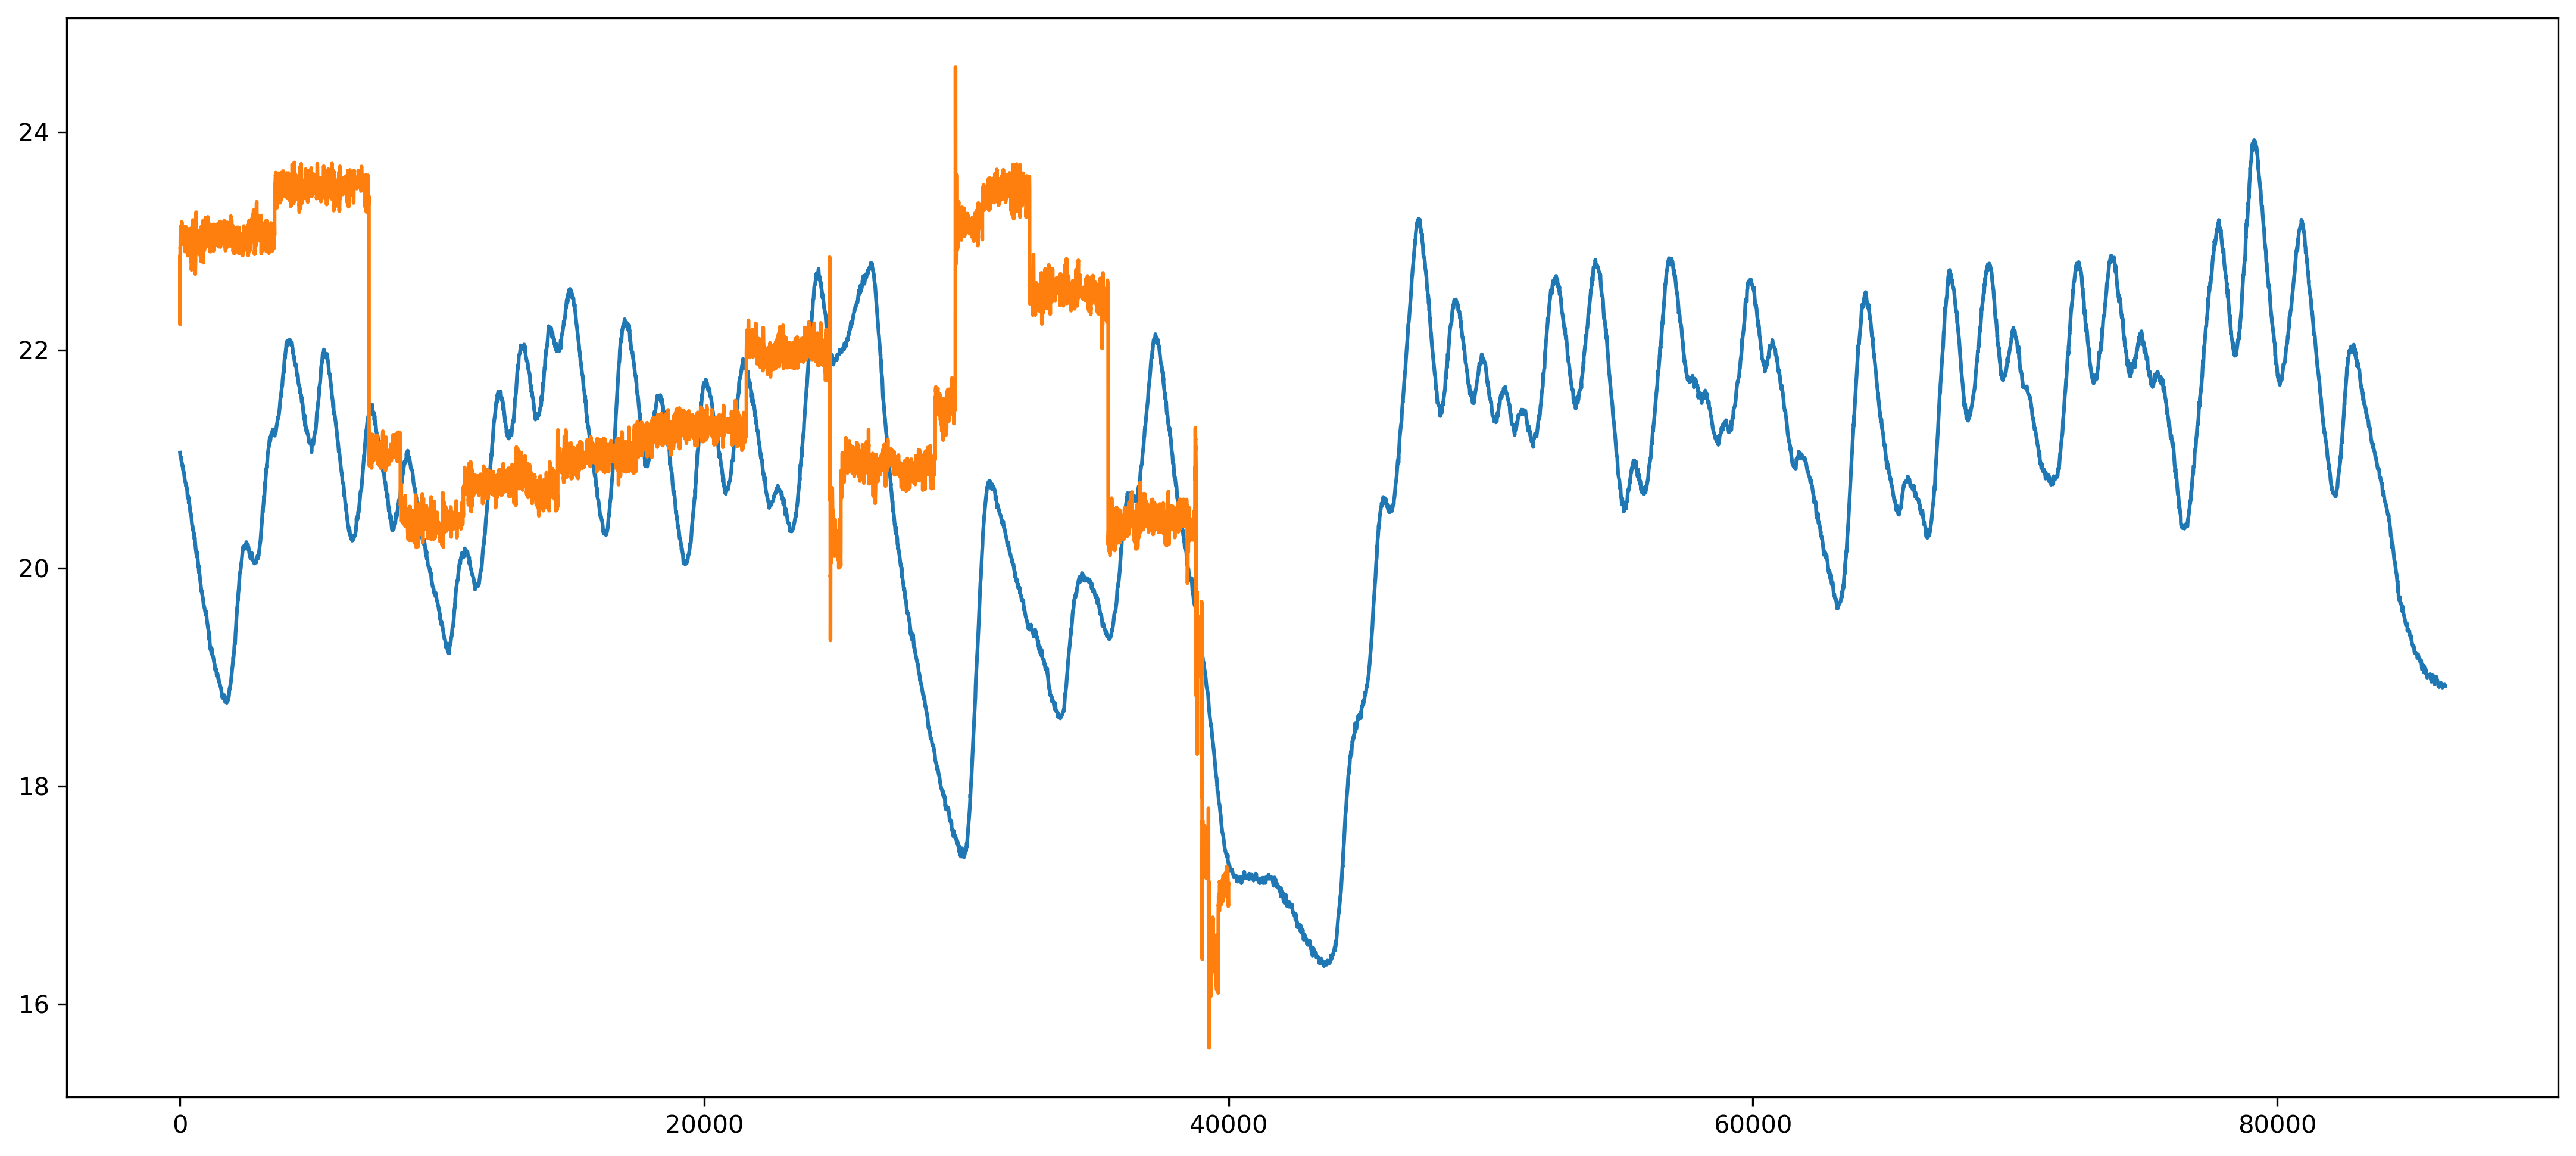

In [212]:
figure(figsize=(18, 8), dpi=300)
x_ax = range(0, len(data_x))
plt.plot(x_ax, data_x[:, 4], x_ax, y_pred2)

In [303]:
def heat_loss_fun(params):
    inp = inp_x
    dr0 = abs(params[0] - inp[0, 4, 0]) > 80
    dr1 = abs(params[1] - inp[0, 4, 1]) > 0.013
    dr2 = abs(params[2] - inp[0, 4, 2]) > 2
    dr3 = params[3] != 13
    if dr0 or dr1 or dr2 or dr3:
        return(9999)
    inp[0, 4, :4] = params
    y_pred = furnance.model_pred(inp)
    loss = abs(heat_loss - y_pred[0, 0])
    return(loss)

In [262]:
def heat_loss_fun2(params):
    inp = inp_x
    inp[0, 4, :4] = params
    y_pred = furnance.model_pred(inp)
    loss = abs(heat_loss - y_pred[0, 0])
    return(loss)

In [258]:
bounds = [(1900, 3500), (65, 81), (40, 70), (13, 27)]
result = dual_annealing(heat_loss_fun, bounds, maxiter=1)
params = result.x.round(2)

In [309]:
def StabiCUlisator(inp_x):
    bounds = [(1900, 3500), (65, 81), (40, 70), (13, 27)]
    result = dual_annealing(heat_loss_fun, bounds, maxiter=1)
    params = result.x.round(2)
    
    xx = inp_x[:, 1:, :]
    xx = np.concatenate((inp_x[:, 4:, :], xx), axis = 1)
    xx[0, 4, :4] = params
    return(xx)

In [329]:
def StabiCUlisator2(inp_x):
    bounds = [(1900, 3500), (65, 81), (40, 70), (13, 27)]
    result = dual_annealing(heat_loss_fun2, bounds, maxiter=1)
    params = result.x.round(2)
    dr0 = params[0] - inp_x[0, 3, 0]
    dr1 = params[1] - inp_x[0, 3, 1]
    dr2 = params[2] - inp_x[0, 3, 2]
    dr3 = params[3]
    #print(params[0])
    #print(inp_x[0, 3, 0])
    if abs(dr0) > 80:
        if dr0 < 0:
            params[0] = inp_x[0, 4, 0] - 80
        else:
            params[0] = inp_x[0, 4, 0] + 80
    if abs(dr1) > 0.013:
        if dr0 < 0:
            params[1] = inp_x[0, 4, 1] - 0.013
        else:
            params[1] = inp_x[0, 4, 1] + 0.013
    if abs(dr2) > 2:
        if dr2 < 0:
            params[2] = inp_x[0, 4, 2] - 2
        else:
            params[2] = inp_x[0, 4, 2] + 2
    if round(dr3) < 18:
        params[3] = 13
    else:
        params[3] = 25
    xx = inp_x[:, 1:, :]
    xx = np.concatenate((xx, inp_x[:, 4:, :]), axis = 1)
    xx[0, 4, :4] = params
    return(xx)

In [341]:
data_x = dfx

(15.0, 25.0)

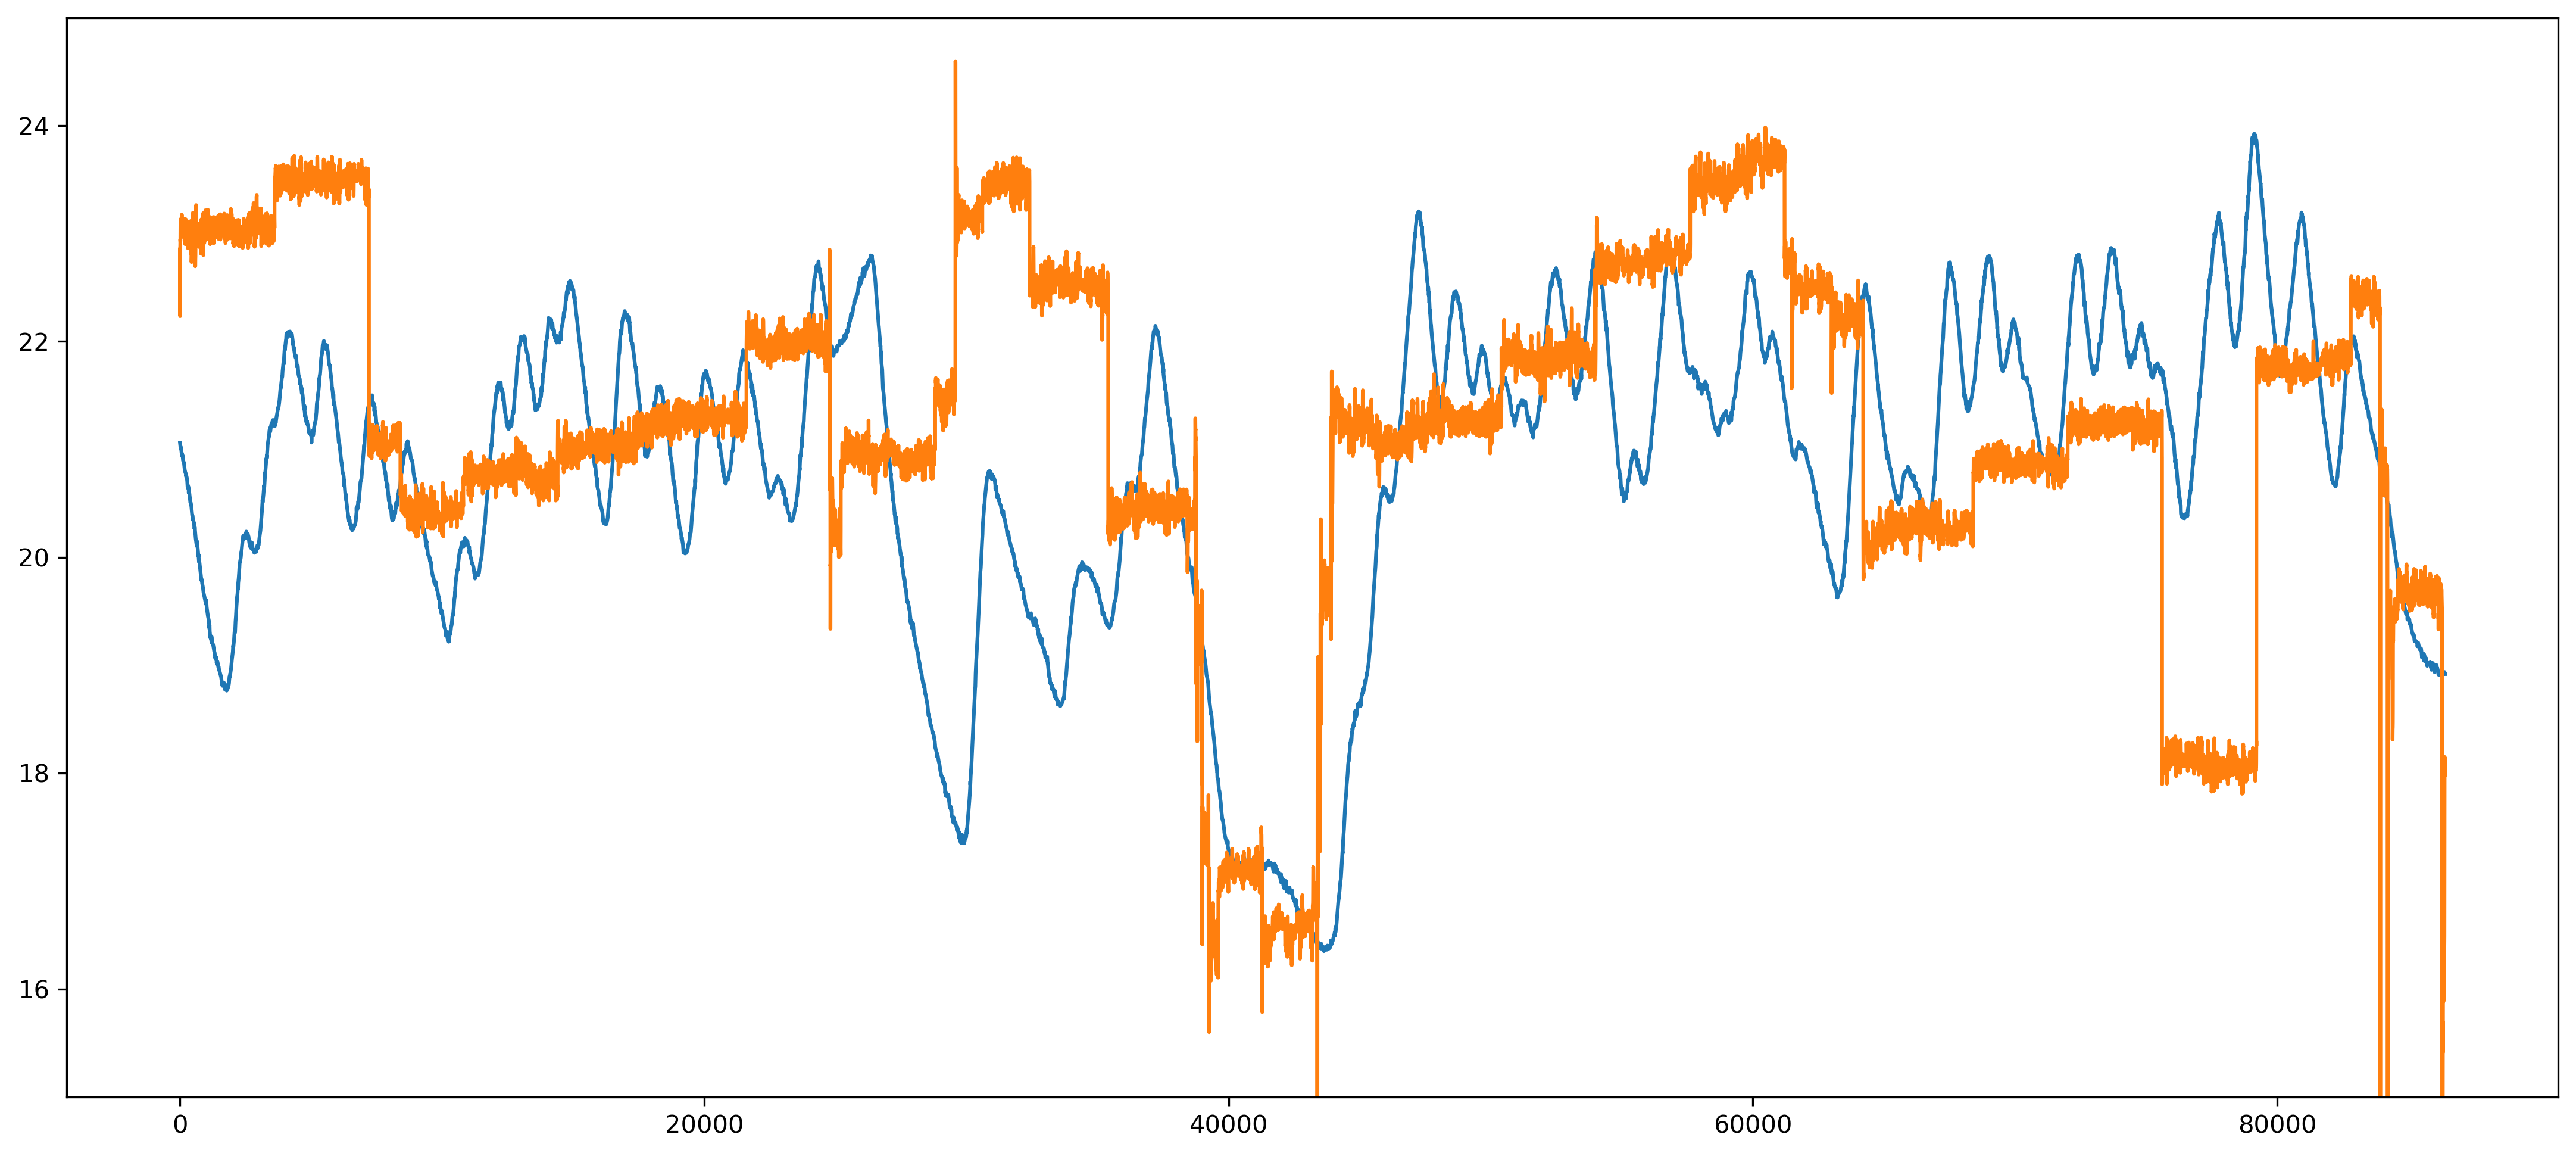

In [343]:
figure(figsize=(18, 8), dpi=300)
x_ax = range(0, len(data_x))
x_r1 = range(0, len(result1))
plt.plot(x_ax, data_x[:, 4], x_ax, y_pred2)
axes = plt.gca()
axes.set_ylim([15,25])

In [211]:
result1 = result

In [217]:
dfx = data_x

In [274]:
bounds = [(1900, 3500), (65, 81), (40, 70), (13, 27)]
result = dual_annealing(heat_loss_fun2, bounds, maxiter=1)
params = result.x.round(2)

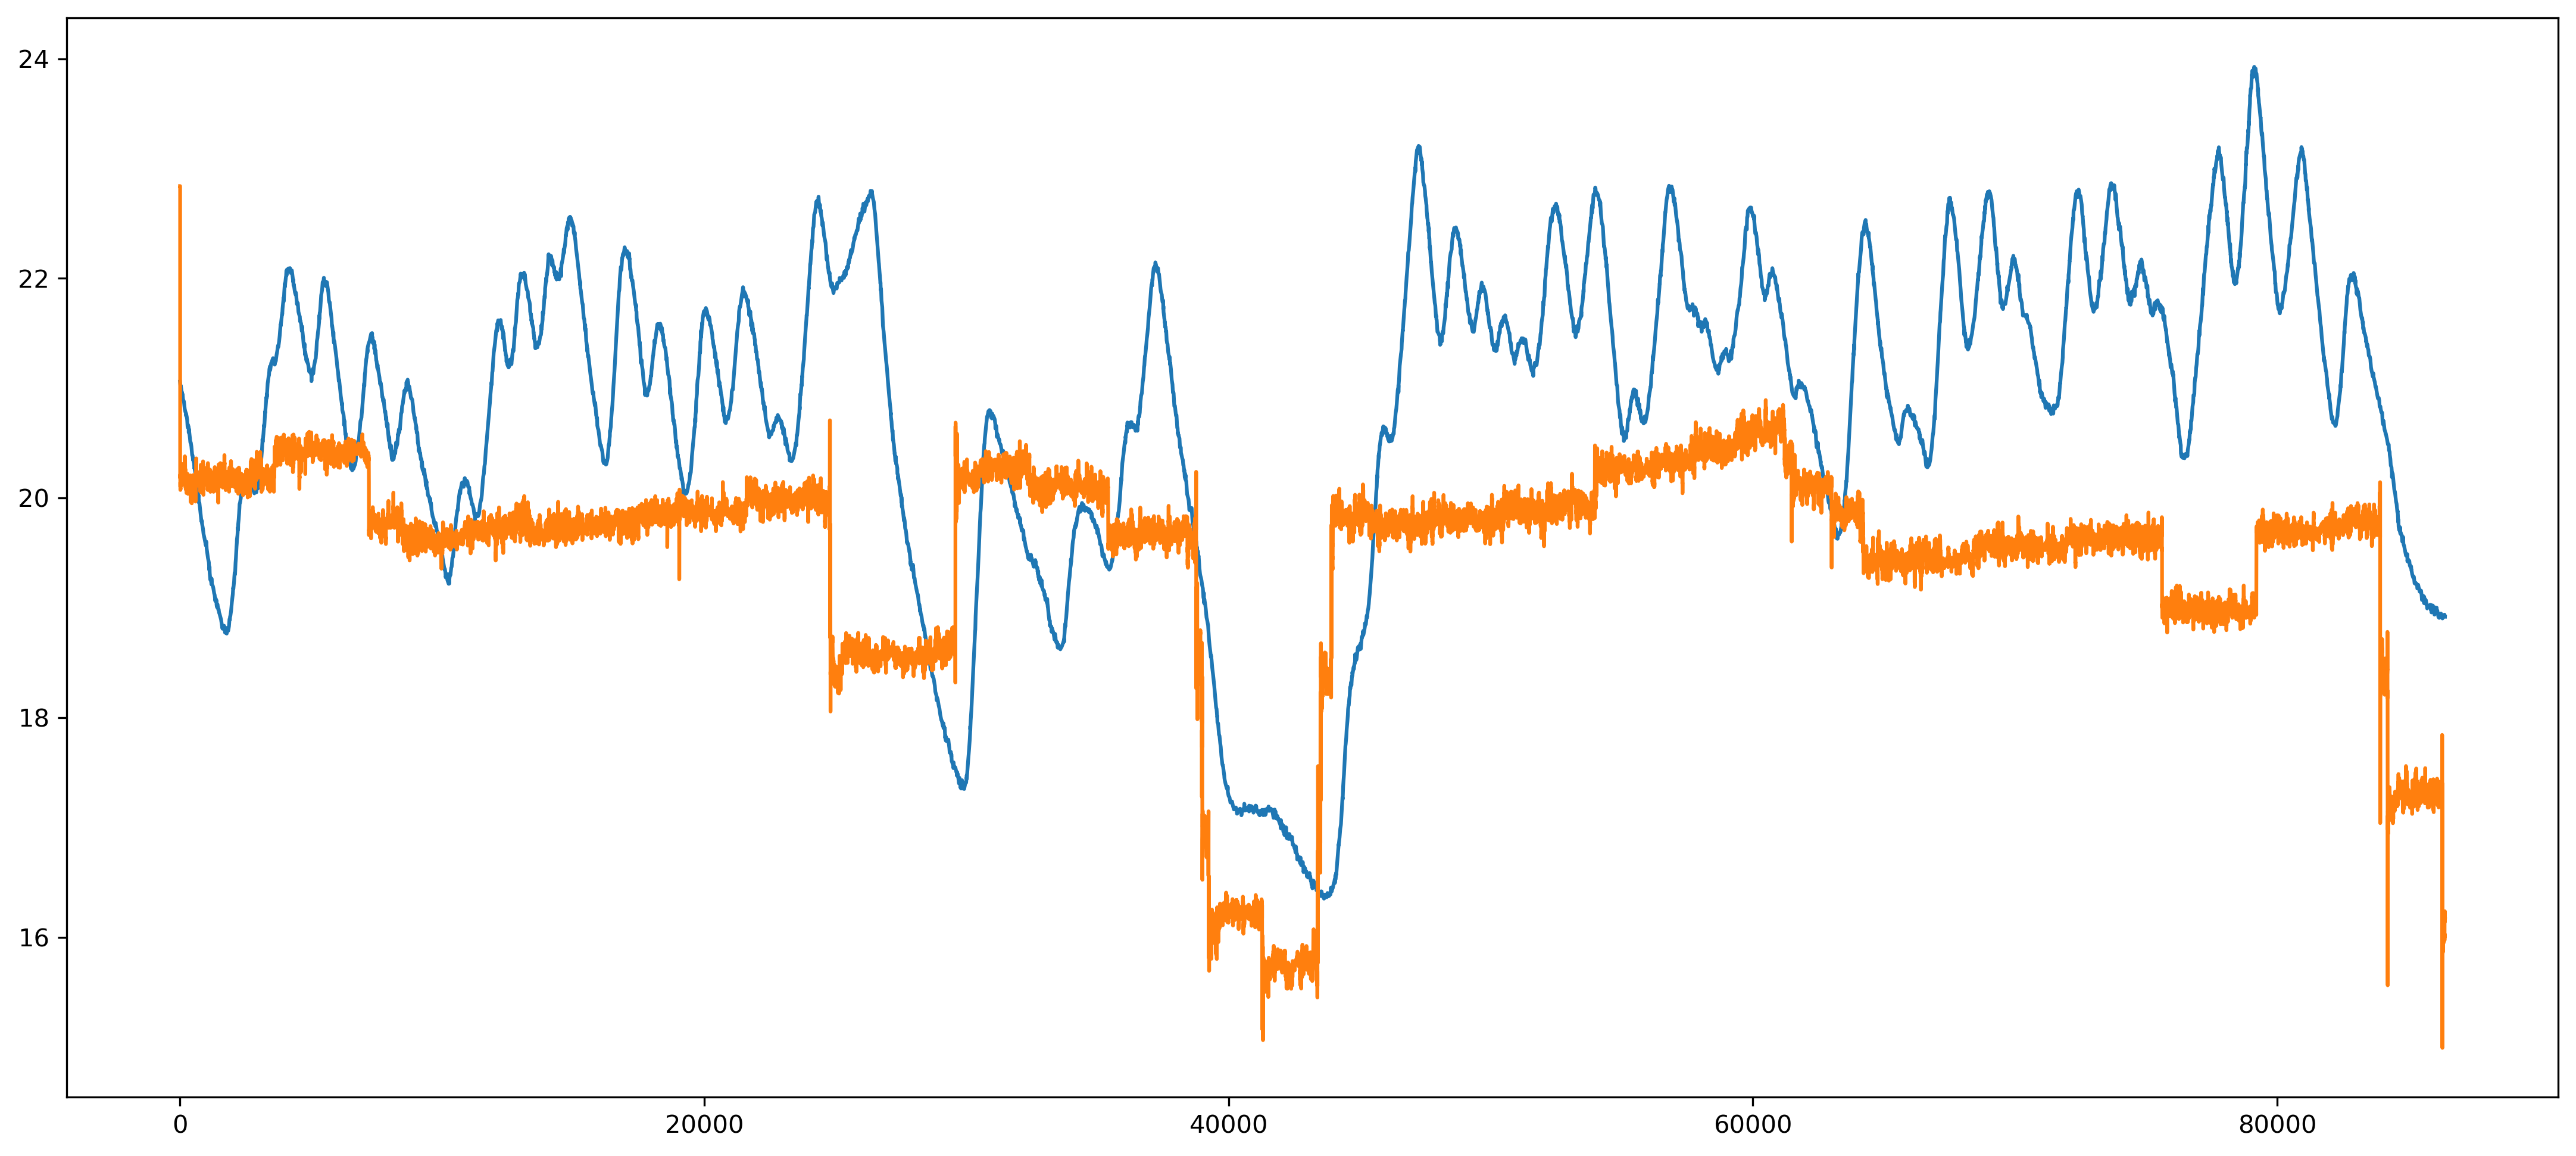

In [84]:
figure(figsize=(18, 8), dpi=300)
x_ax = range(0, len(data_x))
plt.plot(x_ax, data_x[:, 4], x_ax, y_pred2)

In [ ]:
data_x = dfx[37000:, :]
loss_thre = 0.5
heat_loss = data_x[4, 4]
init = True
result = []
params1 = []
for stop in tqdm(range(5, len(data_x))):
    start = stop - 5
    if init:
        inp_x = data_x[start:stop, :].reshape(1,5,26)
    else:
        inp_x = params
        #print(inp_x[:, 4, :4])
    y_pred = furnance.model_pred(inp_x)
    heat_loss1 = y_pred[0, 0]
    if abs(heat_loss - heat_loss1) > loss_thre or not init:
        init = False
        #params = data_x[start+1:stop+1, :].reshape(1,5,26)
        params = StabiCUlisator2(inp_x)
        #print(params[:, 4, :4])
    heat_loss = heat_loss1
    result.append(heat_loss)
    params1.append(params[:, 4, :4])